# **SETUP Libraries for first assignment** 

In [1]:
!pip install -U scikit-learn
!pip install --user -U nltk
!pip install datasetsfrom sklearn.linear_model import LogisticRegression
import nltk

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import csv
import re
from string import punctuation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, classify, NaiveBayesClassifier
from nltk.metrics import ConfusionMatrix


nltk.download('twitter_samples')


ERROR: Could not find a version that satisfies the requirement datasetsfrom (from versions: none)
ERROR: No matching distribution found for datasetsfrom
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Vince\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

# **2° Assignment: Sentiment Analysis**

It is a classification problem whose goal is to extract positive or negative orientations that a writer expresses toward some object like a review of a movie, book, or product on the web and etc.


---



## **Naive Bayes**
In order to do sentiment analysis, we use a **Nayve Bayes classifier**, where the goal is:

\begin{align}
\widehat{c}=\underset{c  \in C}{\mathrm{argmax}}\;P(c|d)=\underset{c  \in C}{\mathrm{argmax}}\;  \frac{P(d|c)P(c)}{P(d)}= \underset{c  \in C}{\mathrm{argmax}}\;P(d|c)P(c)
\end{align}
Where:
- $C$ is the set of classes.
- $c$ is the class
- $d$ is the document, in our case is the tweet.

i.e, we want to find the $\widehat{c}$ class that maximizes posterior probability.

Naïve Bayes makes the independence assumption between features associated witheach class:

\begin{align}
P(f_1,f_2,...,f_n|c)=P(f_1|c)P(f_2|c)...P(f_n|c)
\end{align}

So we have:

\begin{align}
C_{nb}=\underset{c  \in C}{\mathrm{argmax}}\;P(c) \prod_f p(f|c)
\end{align}

To apply NB to text:

\begin{align}
C_{nb}=\underset{c  \in C}{\mathrm{argmax}}\;P(c) \prod_{i \in positions} p(f|c)
\end{align}



### **PREPROCESSING**

We defined a preprocessing function, called `preprocessing(tweet)`, that given a tweet returns a preprocessed list of words that compose it.
### **Preprocessing tasks**
- We remove **urls** using a regular expression.
- We use TweetTokenizer object with wich we can do the tokenization and the lower case.
- We remove the stop words, punctuation and proper names creating sets of these elements and verifying that tokens are not present in these sets.


**Example**
```
#INPUT
sample = "@JetBlue Great flight, as always! Thank you to the great crew on flight 475! # travel #jetblue"

#EXPECTED OUTPUT
['great',
 'flight',
 'alway',
 'thank',
 'great',
 'crew',
 'flight',
 '475',
 'travel',
 '#jetblu']
```




In [2]:
def preprocessing(tweet):
  #REMOVE URL
  tweet_nourls = re.sub(r"http\S+", "", tweet)

  #TOKENIZE AND LOWERCASE
  '''
  * preserve_case (bool) – Flag indicating whether to preserve the casing (capitalisation) of text used in the tokenize method. Defaults to True.
  * reduce_len (bool) – Flag indicating whether to replace repeated character sequences of length 3 or greater with sequences of length 3. Defaults to False.
  * strip_handles (bool) – Flag indicating whether to remove Twitter handles of text used in the tokenize method. Defaults to False.
  '''
  tokenizer = TweetTokenizer(preserve_case = False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet_nourls)

  #REMOVE STOP WORDS, PUNCTUATION AND NAMES
  Stopwords = stopwords.words('english')
  Punctuation = list(punctuation)
  male_female = names.words('male.txt') + names.words('female.txt')
  clean_tweets = []
  porter_stemmer  = PorterStemmer()
  for token in tweet_tokens:
    if (token not in Stopwords and token not in Punctuation and token not in male_female):
      clean_tweets.append(porter_stemmer.stem(token))

  return clean_tweets

### **Bag_of_words**
We define a function which performs feature extraction, called `bag_of_words(tweet)`, that given a tweet as input returns the dictionary formed by the key-value pairs, where the keys are the preprocessed tweet words and the value is set to TRUE if the key is to be considered by the model, FALSE otherwise.

**NB**: in this we set everything to **TRUE** because we implicitly remove the **FALSE** words (with preprocessing)


**Example**
```
#INPUT
sample = "@JetBlue Great flight, as always! Thank you to the great crew on flight 475! # travel #jetblue"

#OUTPUT
{'great': True,
 'flight': True,
 'alway': True,
 'thank': True,
 'crew': True,
 '475': True,
 'travel': True,
 '#jetblu': True}
```



In [3]:
#feature extractor function
def bag_of_words(tweet):
  words = preprocessing(tweet)
  #TRUE = the word must be considered by the algorithm
  words_dictionary = dict([word, True] for word in words)
  return words_dictionary


### **Training Set and Test Set** 
Once we define the functions that allow us to prepare the input that we give to the Naive Bayes model implemented by NLTK, we create an unique set formed by the pairs (tweet, label), and after splits this into:


*   75% Training set
*   15% Test set, where divide into 5 subsets.

We use the tweets defined by the nltk and the tweets present in a csv file.

In [4]:
pos_tweets_set = []
neg_tweets_set = []

positive_t = twitter_samples.strings('positive_tweets.json')
negative_t = twitter_samples.strings('negative_tweets.json')

for tweet in positive_t:
  pos_tweets_set.append((bag_of_words(tweet),'pos'))
for tweet in negative_t:
  neg_tweets_set.append((bag_of_words(tweet),'neg'))

with open("./twitter_sentences.csv",encoding="utf-8") as csvfile:
  reader = csv.reader(csvfile, delimiter = ",")
  for row in reader:
    if row[0] == 'negative':
      neg_tweets_set.append((bag_of_words(row[1]),'neg'))
    else:
      pos_tweets_set.append((bag_of_words(row[1]),'pos'))

tweets_set = pos_tweets_set + neg_tweets_set

In [5]:

from nltk.inference import tableau

#keys: we want just print keys without "true" or "false" values of dictionaries
dict_feature = {
    "FEATURE": [pos_tweets_set[0][0].keys(), pos_tweets_set[int(len(pos_tweets_set)/2)][0].keys(), pos_tweets_set[len(pos_tweets_set)-1][0].keys(), neg_tweets_set[0][0].keys(), neg_tweets_set[int(len(neg_tweets_set)/2)][0].keys(),neg_tweets_set[len(neg_tweets_set)-1][0].keys()],
    "LABEL": [pos_tweets_set[0][1], pos_tweets_set[int(len(pos_tweets_set)/2)][1], pos_tweets_set[len(pos_tweets_set)-1][1], neg_tweets_set[0][1], neg_tweets_set[int(len(neg_tweets_set)/2)][1], neg_tweets_set[len(neg_tweets_set)-1][1]]
}

table = pd.DataFrame(data=dict_feature)
print(f"\tTABLE EXAMPLE\n{table}")



	TABLE EXAMPLE
                                             FEATURE LABEL
0  (#followfriday, top, engag, member, commun, we...   pos
1  (someth, weekend, here', bodi, weight, workout...   pos
2   (new, f, dfw, clt, morn, great, job, well, done)   pos
3                                (hopeless, tmr, :()   neg
4  (better, train, support, staff, appropri, deco...   neg
5          (board, plane, know, maint, issu, us5235)   neg


In [6]:
#Shuffle the entire set of tweets
random.shuffle(tweets_set) 

#75% of the set is given to the training set
training_set = tweets_set[:int(len(tweets_set)*0.75)]

#15% of the set is given to the test set, and we split this into 5 subsets
test_splits = np.array_split(tweets_set[int(len(tweets_set)*0.75):],5)

### **Training**
In order to do NBC training, we do:
1. Count up how many times each feature value occurred, given the label and featurename.
2. Compute the likelihood for each word.
\begin{align}
 P(w_i|class) = \frac{freq(w_i, class) + 1}{N_{class}+V}
\end{align}
where: $N_{class}$ is the frequency of all words in class and $V$ is the number of unique words in vocabulary.
3. Get $\lambda(w)$:
\begin{align}
\lambda(w) = \frac{P(w_i|class_1)}{P(w_i|class_2)} 
\end{align} 
where: $ class_1 = positive$ e $class_2 = negative $
4. Compute the prior ratio 
\begin{align}
\frac{P(class_1)}{P(class_2)}
\end{align} 

**Naive Bayes formula for binary classification**: 
\begin{align}
NB = \frac{P(class_1)}{P(class_2)} \prod_{i=1}^{n}\lambda(w_i)
\end{align} 
where:
- if $NB > 1$ the output label is positive. 
- else if $NB < 1$ the output label is negative. 
- else if $NB = 1$ the output label is neutral.

To avoid multiplications among very small value we apply the **logarithmic transformation**.
\begin{align}
log\frac{P(class_1)}{P(class_2)} + \sum_{i=1}^n log\frac{P(w_i|class_1)}{P(w_i|class_2)} 
\end{align} 

In [7]:
#NAIVE BAYES CLASSIFIER
NBClassifier = NaiveBayesClassifier.train(training_set)

### **Testing and Evaluation**
After training our model, we do the testing using 5 test sets. For each we compute the:
* **Confusion Matrix**: a confusion matrix is a table for visualizing how an algorithm performs with respect to the human gold labels
* **Precision**: the ratio of correctly classified positive samples (True Positive) to a total number of classified positive samples (either correctly or incorrectly). Is a percentage that tells us how likely the prediction is correct.
\begin{align}
\text{Precision} = \frac{TP}{TP+FP}
\end{align}
* **Recall**:  the ratio between the numbers of Positive samples correctly classified as Positive to the total number of Positive samples. The **recall measures** the model's ability to detect positive samples. The higher the recall, the more positive samples detected.
\begin{align}
\text{Recall} = \frac{TP}{TP+FN}
\end{align}
* **F-measure**: is a measure of a model’s accuracy on a dataset. It is used to evaluate binary classification systems. Is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall. \begin{align}
F_{β}= \frac{(β^2 + 1) × \text{Precision} × \text{Recall}}{{β^2 ×\text{Precisión} + \text{Recall}}}
\end{align}
Based on the $β$  value, the importance of precision or recall is determined
* **Accuracy**: accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:

\begin{align}
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
\end{align}


In [8]:
def ComputeConfusionMatrix(predicted_out, real_out):
  cm = ConfusionMatrix(predicted_out,real_out)
  return cm

In [9]:

def displayConfusionMatrix(cm):
  true_positive = cm["pos","pos"]
  false_positive = cm["pos", "neg"]
  true_negative = cm["neg","neg"]
  false_negative = cm["neg","pos"]
  matrix = np.array([[true_positive, false_positive], [false_negative, true_negative]])
  df_confusionMatrix = pd.DataFrame(matrix, columns=["pos", "neg"], index=["pos","neg"])

  df_confusionMatrix = df_confusionMatrix.style.set_caption("Confusion Matrix").set_table_styles([{'selector': 'caption',
    "props":[("text-align", "center")]
  }])

  display(df_confusionMatrix)

In [10]:
def displayEvaluation(cm,accuracy):
  pos_precision = cm.precision("pos")
  pos_recall = cm.recall("pos")
  neg_precision = cm.precision("neg")
  neg_recall = cm.recall("neg")
  pos_f_measure = cm.f_measure("pos")
  neg_f_measure = cm.f_measure("neg")

  evaluation_array = np.array([[pos_precision,pos_recall, pos_f_measure,accuracy], [neg_precision,neg_recall,neg_f_measure,accuracy]])
  df_evaluation = pd.DataFrame(evaluation_array,columns=["precision","recall","f_measure","accuracy"],index=["pos","neg"])

  df_evaluation = df_evaluation.style.set_caption("Evaluations").set_table_styles([{'selector': 'caption',
    "props":[("text-align", "center")]
  }])

  display(df_evaluation)


In [11]:
acc = []
for tweet in test_splits:
  acc.append(classify.accuracy(NBClassifier, tweet))
  #UNPACKING OPERATOR -> *
  # https://www.geeksforgeeks.org/python-get-first-element-of-each-sublist/
  pos_neg_tweets = list(list(zip(*tweet))[0]) #Only the tweets
  real_out_sets = list(list(zip(*tweet))[1]) # Only the labels
  cm = ComputeConfusionMatrix(NBClassifier.classify_many(pos_neg_tweets), real_out_sets)
  displayConfusionMatrix(cm)
  displayEvaluation(cm,classify.accuracy(NBClassifier, tweet))
  
accuracy = np.array(acc)
print("Accuracy's StdDev: ",  accuracy.std())
print("Accuracy's mean", accuracy.mean())

,pos,neg
pos,288,6
neg,37,549


,precision,recall,f_measure,accuracy
pos,0.886154,0.979592,0.930533,0.951136
neg,0.989189,0.936860,0.962314,0.951136


,pos,neg
pos,293,9
neg,36,542


,precision,recall,f_measure,accuracy
pos,0.890578,0.970199,0.928685,0.948864
neg,0.983666,0.937716,0.960142,0.948864


,pos,neg
pos,321,6
neg,44,509


,precision,recall,f_measure,accuracy
pos,0.879452,0.981651,0.927746,0.943182
neg,0.988350,0.920434,0.953184,0.943182


,pos,neg
pos,280,6
neg,64,529


,precision,recall,f_measure,accuracy
pos,0.813953,0.979021,0.888889,0.920364
neg,0.988785,0.892074,0.937943,0.920364


,pos,neg
pos,316,6
neg,47,510


,precision,recall,f_measure,accuracy
pos,0.870523,0.981366,0.922628,0.939704
neg,0.988372,0.915619,0.950606,0.939704


Accuracy's StdDev:  0.010920183451033221
Accuracy's mean 0.9406500155134967


**Example**

Given a new tweet we calculate the probability that it is `'pos'` or `'neg'`.

In [12]:
tweet = 'The more I use @salesforce the more I dislike it. It\'s slow and full of bugs. There are elements of the UI that look like they haven\'t been updated since 2006. Current frustration: app exchange pages won\'t stop refreshing every 10 seconds'

print(NBClassifier.classify(bag_of_words(tweet)), ': ', tweet)
prob = NBClassifier.prob_classify(bag_of_words(tweet))
print('Probability of pos: ', prob.prob('pos'))
print('Probability of neg: ', prob.prob('neg'))

neg :  The more I use @salesforce the more I dislike it. It's slow and full of bugs. There are elements of the UI that look like they haven't been updated since 2006. Current frustration: app exchange pages won't stop refreshing every 10 seconds
Probability of pos:  8.81525982122856e-07
Probability of neg:  0.9999991184740158


## **LOGISTIC REGRESSION CLASSIFIER**

In order to do what is required we import the necessary modules and create two sets of positive and negative tweets using the `twitter_samples` module from NTLK. In this case we use the module LogisticRegression implemented by scikit-learn.

### **Logistic or Sigmoid function** 
Logistic Regression Classifier is based on the sigmoid (or logistic) function that makes use of the sigmoid function which outputs a probability between 0 and 1, i.e:

\begin{align}
0 \leq h_{\theta}(x) \leq 1 
\end{align}

where: 

\begin{align}
h_{\theta}(x) =  g({\theta}^{T} * x) = \frac{1}{1+e^{-{\theta}^T}*x}
\end{align}

$g$ is the non-linear, continuous and non-differentiable function.
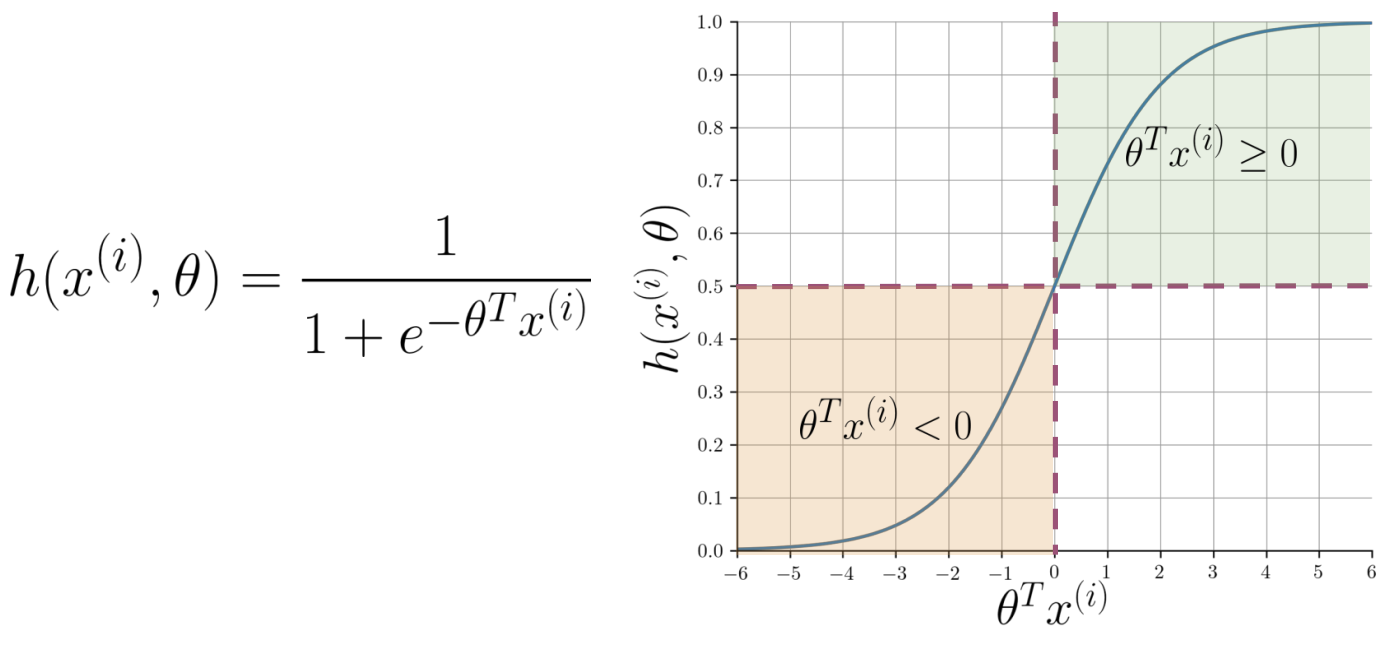


### **PREPROCESSING**

We defined a preprocessing function, called `preprocessingLR(tweet)`, that given a tweet returns a preprocessed tweet.
#### **Preprocessing tasks**
- We remove **urls** using a regular expression.
- We use TweetTokenizer object with wich we can do the tokenization and the lower case.
- We remove the stop words, punctuation and proper names creating sets of these elements and verifying that tokens are not present in these sets.


**Example**
```
#INPUT
sample = "@JetBlue Great flight, as always! Thank you to the great crew on flight 475! # travel #jetblue"

#EXPECTED OUTPUT
"great flight alway thank great crew flight 475 travel #jetblu"
```




In [13]:
def preprocessingLR(tweet):
  #REMOVE URL
  tweet = re.sub(r"http\S+", "", tweet)

  #TOKENIZE AND LOWERCASE
  tokenizer = TweetTokenizer(preserve_case = False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  #REMOVE STOP WORDS, PUNCTUATION AND NAMES
  Stopwords = stopwords.words('english')
  Punctuation = list(punctuation)
  male_female = names.words('male.txt') + names.words('female.txt')
  clean_tweets = []
  porter_stemmer  = PorterStemmer()
  for token in tweet_tokens:
    if token not in Stopwords and token not in Punctuation and token not in male_female:
      clean_tweets.append(porter_stemmer.stem(token))

  return ' '.join(clean_tweets)


#INPUT
tweet = "@JetBlue Great flight, as always! Thank you to the great crew on flight 475! # travel #jetblue"
preprocessingLR(tweet)

'great flight alway thank great crew flight 475 travel #jetblu'

### **Features extraction**
From the input files we create a sets containing all tweets and a set containing their respective labels.
Using the `fit_transform()` function of `CountVectorizer` object we transform the sentences into a sparse word-document matrix turning words into lowercase.

In [14]:
data = []
data_labels = []

for i in twitter_samples.strings('positive_tweets.json'): 
  data.append(preprocessingLR(i)) 
  data_labels.append('pos')

for i in twitter_samples.strings('negative_tweets.json'): 
  data.append(preprocessingLR(i))
  data_labels.append('neg')

with open("./twitter_sentences.csv",encoding="utf-8") as csvfile:
  reader = csv.reader(csvfile, delimiter = ",")
  for row in reader:
    if row[0] == 'negative':
      data.append(preprocessingLR(row[1]))
      data_labels.append('neg')
    else:
      data.append(preprocessingLR(row[1]))
      data_labels.append('pos')


vectorizer = CountVectorizer(analyzer = 'word', lowercase = True)
features = vectorizer.fit_transform(data) #FEATURES = DOCUMENT TERM MATRIX


### **Splitting** 
We split the data into training set and test set (75% - 25%), with respective output sets, using the bult-in scikit-learn's function `train_test_split()`.
We use the same function for splitting the test set into 4 subsets, each one of 25%.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features,data_labels)

x1_test, x2_test, y1_test, y2_test = train_test_split(x_test, y_test, train_size=0.5)

x3_test, x4_test, y3_test, y4_test = train_test_split(x1_test, y1_test, train_size=0.5)#25%

x1_test, x2_test, y1_test, y2_test = train_test_split(x2_test, y2_test, train_size=0.5) # 25%


### **Training**
Since $h_{\theta}(x)$ depends on $\theta$ parameters the goal of the training function is to find $\theta$ parameters such that they minimize the Cost function.
#### **Cost function**

\begin{align}
Cost(h_{\theta}(x),y) =\begin{cases} {-\log (h_{\theta}(x))} & \mbox{if } \mbox{ y = 1}\\ {-\log ( 1 - h_{\theta}(x)) } & \mbox{if } \mbox{ y = 0} \end{cases}
\end{align}

i.e, if the model predicts an output different from the associated output then it is penalized with a high cost, otherwise the cost is 0.

Since y = 0 or 1 (always):

\begin{align}
Cost(h_{\theta}(x),y) =  - y\log (h_{\theta}(x))- (1 - y)\log ( 1 - h_{\theta}(x))
\end{align}

i.e, the **cross entropy**.

Since the cost function applies to each pattern in our case we define the $J(\theta)$ function as the average of the cost functions of the individual patterns:

\begin{align}
J(\theta) = \frac{1}{m} \sum_{i = 0}^m Cost(h_{\theta}(x^i),y^i)
\end{align}

The goal is to minimize $J(\theta)$, and to do this we use the **gradient descent** technique:

\begin{align}
\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m} \sum_{i = 0}^m Cost(h_{\theta}(x^i) - y^i)x_{j}^{(i)}
\end{align}
<br>

#### **LR training**

To train the LR Model we have to:
- initialize ${\theta}$ parameter
- compute the gradient to update theta
- calculate the cost until good enough




In [16]:
#MODEL FIT
LRClassifier = LogisticRegression( max_iter=10000)
LRClassifier.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

### **Evaluation**
We create two sets, the first containing the patterns, the second their respective labels. We use them to calculate the **Confusion Matrix** and measures: **recall, precision and f-score**.


ACCURACY = 0.8080072793448589


,neg,pos
recall,0.835694,0.758270
precision,0.861314,0.719807
f_measure,0.848311,0.738538


ACCURACY = 0.7972727272727272


,neg,pos
recall,0.831933,0.733161
precision,0.852224,0.702233
f_measure,0.841956,0.717364


ACCURACY = 0.8007279344858963


,neg,pos
recall,0.813314,0.779412
precision,0.861963,0.711409
f_measure,0.836932,0.743860


ACCURACY = 0.7963636363636364


,neg,pos
recall,0.830791,0.730871
precision,0.854494,0.694236
f_measure,0.842475,0.712082


Accuracy's StdDev:  0.004579887368334473
Accuracy's mean 0.8005928943667797


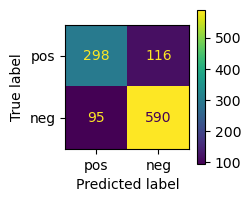

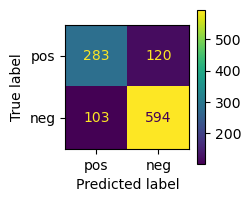

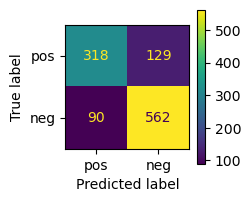

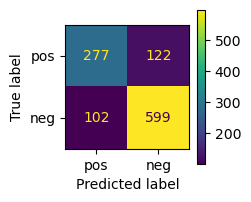

In [17]:
predict_test =[LRClassifier.predict(x1_test),LRClassifier.predict(x2_test), LRClassifier.predict(x3_test), LRClassifier.predict(x4_test)] 

Y_TEST = [y1_test,y2_test,y3_test,y4_test]
mat_list = []
accuracies = []
df_metrics = None
for y_pred,y_true in zip(predict_test,Y_TEST):
  accuracies.append(accuracy_score(y_true,y_pred))
  mat = confusion_matrix(y_true,y_pred, labels=["pos","neg"])
  df_metrics = pd.DataFrame(precision_recall_fscore_support(y_true,y_pred)[:3], columns = ["neg","pos"], index = ["recall","precision","f_measure"])
  disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["pos","neg"])
  fig, ax = plt.subplots(figsize=(2,2))  
  disp.plot(ax=ax)
  print("ACCURACY =", accuracy_score(y_true,y_pred))
  display(df_metrics)

accuracies = np.array(accuracies)
print("Accuracy's StdDev: ",  accuracies.std())
print("Accuracy's mean", accuracies.mean())

**Example**

Given a new tweet we calculate the probability that it is `'pos'` or `'neg'`.

In [18]:
#INPUT TEST
tweet = 'The other day I had a pizza in Puglia, but it looked like a cookie. Really horrible and inedible'
List = []
List.append(preprocessingLR(tweet))

INPUT = vectorizer.transform(List) #Features extraction for the sample

print(f'Result: {LRClassifier.predict(INPUT)}\n with prob: {LRClassifier.predict_proba(INPUT)}')

Result: ['neg']
 with prob: [[0.89728656 0.10271344]]
